In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit.quantum_info as qinfo

from qiskit import Aer, execute, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import PassManager
from qiskit.circuit import Delay, Barrier

In [2]:
def get_random_circuit(num_qubits, num_gates, cumul_prob=[2/5, 4/5]):
    circ = QuantumCircuit(num_qubits)
    for i in range(num_gates):
        r = np.random.rand()
        if r < cumul_prob[0]:
            circ.rx(2 * np.pi * np.random.rand(), np.random.randint(num_qubits))
        elif r < cumul_prob[1]:
            circ.ry(2 * np.pi * np.random.rand(), np.random.randint(num_qubits))
        else:
            p = np.random.randint(num_qubits - 1)
            circ.cz(p, p + 1)
    return circ

# Pass managers

In [3]:
class SequentialPass(TransformationPass):
    """Adds barriers between gates."""
    
    def run(self, dag):
        new_dag = DAGCircuit()
        
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)
        for node in dag.op_nodes():
            if node.name in ['barrier', 'measure']:
                continue
            new_dag.apply_operation_back(node.op, node.qargs, node.cargs)
            new_dag.apply_operation_back(Barrier(new_dag.num_qubits()), list(new_dag.qubits), [])
    
        return new_dag
    
class LinearTopologyParallelPass(TransformationPass):
    """Adds barriers between gates such that no two qubit gates are executed
    at the same time and only single qubit gates on non-neighboring qubits can
    be executed in parallel. It assumes a linear topology."""
    
    def run(self, dag):
        new_dag = DAGCircuit()
        
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)
        
        for layer in dag.layers():
            gates_1q = []
            gates_2q = []
            for node in layer['graph'].op_nodes():
                if len(node.qargs) == 2:
                    gates_2q.append(node)
                else:
                    gates_1q.append(node)
            
            even = []
            odd = []
            for node in gates_1q:
                if node.qargs[0].index % 2 == 0:
                    even.append(node)
                else:
                    odd.append(node)

            if len(even) > 0:
                for node in even:
                    new_dag.apply_operation_back(node.op, node.qargs, node.cargs)
                new_dag.apply_operation_back(Barrier(new_dag.num_qubits()), list(new_dag.qubits), [])

            if len(odd) > 0:
                for node in odd:
                    new_dag.apply_operation_back(node.op, node.qargs, node.cargs)
                new_dag.apply_operation_back(Barrier(new_dag.num_qubits()), list(new_dag.qubits), [])
            
            for node in gates_2q:
                new_dag.apply_operation_back(node.op, node.qargs, node.cargs)
                new_dag.apply_operation_back(Barrier(new_dag.num_qubits()), list(new_dag.qubits), [])

        return new_dag    

class DelayPass(TransformationPass):
    """Adds delay gates when the qubits are idle.
    For every layer of the circuit it finds the gate that 
    lasts the longest and applies appropriate delays on the
    other qubits.
    """
    
    def __init__(self, gate_durations):
        """
        Args:
            gate_durations (Dict): Gate durations in the units of dt
        """
        super().__init__()
        self.gate_durations = gate_durations
    
    def run(self, dag):
        new_dag = DAGCircuit()
        
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)
        for layer in dag.layers():
            max_duration = 0
            durations = {}
            for node in layer['graph'].op_nodes():
                if node.name in self.gate_durations:
                    max_duration = max(max_duration, self.gate_durations[node.name])
                    for q in node.qargs:
                        durations[q] = self.gate_durations[node.name]
                new_dag.apply_operation_back(node.op, node.qargs, node.cargs)
            
            partition = layer['partition']
            if len(partition) == 0:
                continue
            lst = list(dag.qubits)
            for el in partition:
                for q in el:
                    if q in lst:
                        lst.remove(q)
            for el in lst:
                new_dag.apply_operation_back(Delay(max_duration), [el], [])
            for q in durations:
                if max_duration - durations[q] > 0:
                    new_dag.apply_operation_back(Delay(max_duration - durations[q]), q, [])
            
        return new_dag

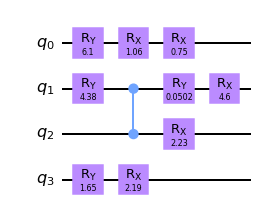

In [4]:
circ = get_random_circuit(4, 10)
circ.draw('mpl')

<ipython-input-3-2b2483c389c5>:44: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if node.qargs[0].index % 2 == 0:


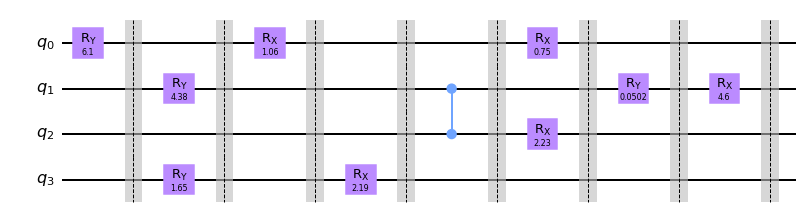

In [5]:
par_pm = PassManager()
par_pm.append([LinearTopologyParallelPass()])
circ = par_pm.run(circ)
circ.draw('mpl')

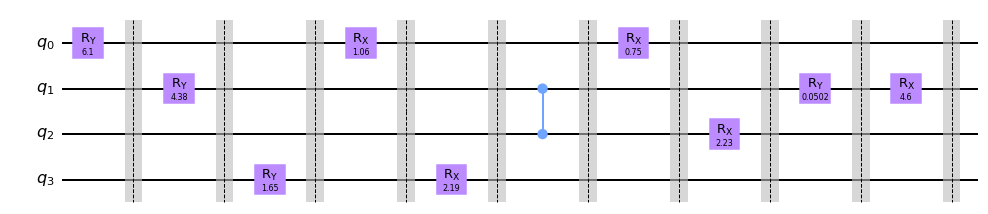

In [6]:
seq_pm = PassManager()
seq_pm.append([SequentialPass()])
circ = seq_pm.run(circ)
circ.draw('mpl')

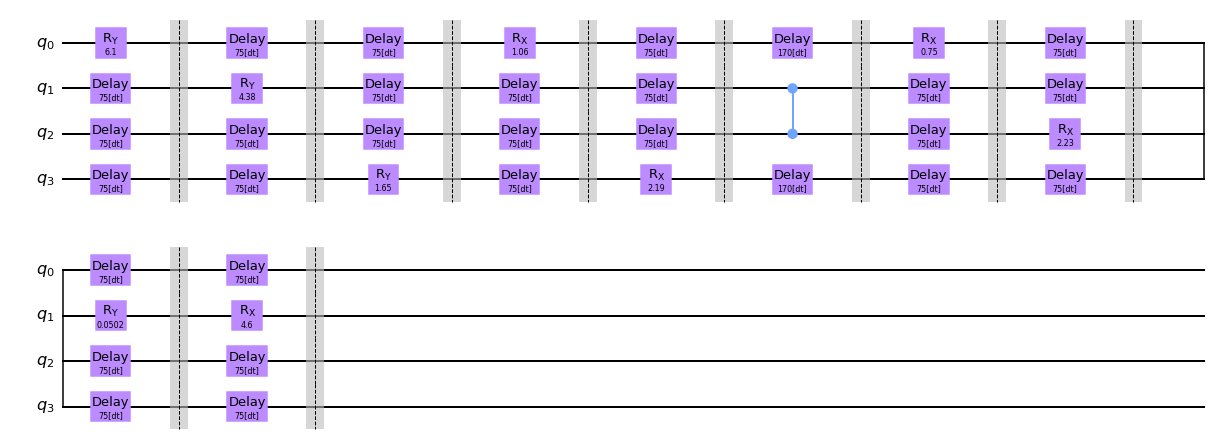

In [7]:
dpm = PassManager()
dpm.append([DelayPass({'rx': 75, 'ry': 75, 'cz': 170})])
circ = dpm.run(circ)
circ.draw('mpl')